In [1]:
import numpy as np
from scipy.io import loadmat
from h5py import File
from multiprocessing import Pool
from functools import partial
from skimage.exposure import rescale_intensity

In [352]:
def get_mika_timeseries(path, roi=None, key='T'):
    '''
    Load data from Cells0_clust.mat as a numpy array.
    '''
    from h5py import File
    with File(path) as f:
        if roi is not None:
            ts = f[key][roi]
        else:
            ts = f[key].value
    return ts

def clean_coord(coord):
    return [c[~np.isnan(c)].astype('int') for c in coord]

def get_mika_coords(path):
    '''
    Load zyx coordinates for superpixels from Cells0_clean.mat, 
    Return coords as a list of tuples along with dims of bounding box of all superpixels
    '''
    from h5py import File
    with File(path) as f:
        coords = (f['Cell_Z'][:].T - 1, f['Cell_Y'][:].T - 1, f['Cell_X'][:].T - 1)
    
    dims = [int(np.nanmax(c)) + 1 for c in coords]
    cleaned = list(zip(*[clean_coord(coord) for coord in coords]))
    return cleaned, dims

# reconstruct a volume for each timepoint
def reconstruct_vol(timepoint, coords, dims, ds_xy = 1, fill_value=0, dtype='float32'):
    from numpy import zeros, array
    vol = zeros(dims, dtype=dtype) + fill_value;
    for ind,spx in enumerate(timepoint):
        coord_array = array([coords[ind][0], coords[ind][1], coords[ind][2]])
        vol[coord_array[0], coord_array[1], coord_array[2]]= spx
    return vol[:,::ds_xy, ::ds_xy]

In [3]:
base_dir = '/groups/ahrens/ahrenslab/mika/yu/data/glia/20161012_1_1_cy221_6dpf_0gain_wholebrain_20161012_113040/' 

In [696]:
exp_name = '20161012_1_1_cy221_6dpf_0gain_wholebrain_20161012_113040'

In [6]:
with File(base_dir + 'ephys/data.mat') as f:
    epdat = {k: np.squeeze(f['data'][k]) for k in f['data'].keys()}
# there are some dodgy values in here, where the time between giving up is like 5s...
gu_onsets = loadmat(base_dir + 'ephys/GU_onset.mat', squeeze_me=True)['GU_onset']

In [699]:
window = np.arange(-10,20)
gu_frames = [epdat['frame'][guo] for guo in gu_onsets]
gu_frames = list(filter(lambda v: (v+window).max() < epdat['frame'].max(), gu_frames))
gu_frames = np.array(gu_frames).astype('int')
gu_frames = gu_frames[1:][np.diff(gu_frames) > len(window)]
plr = (gu_frames.reshape(-1,1) + window).ravel()

In [10]:
%%time
# mika ignores first 130 frames
roi = (plr, slice(None))
ts = get_mika_timeseries(base_dir + 'ana/Cells0_clust.mat', roi = roi)
coords,dims = get_mika_coords(base_dir + 'ana/Cells0_clean.mat')

CPU times: user 2min 48s, sys: 3.59 s, total: 2min 52s
Wall time: 2min 52s


In [11]:
%%time
recon = partial(reconstruct_vol, coords=coords, dims = dims, ds_xy=4)
with Pool(8) as p:
    result = np.array(p.map(recon, ts))

CPU times: user 1min 14s, sys: 30.6 s, total: 1min 45s
Wall time: 4min 21s


In [12]:
result.shape

(1590, 35, 110, 255)

In [13]:
result = rescale_intensity(result, out_range='uint16').astype('uint16')

In [14]:
result_tr = result.reshape(result.shape[0] // len(window),len(window), *result.shape[1:])

In [15]:
result_tr.shape

(53, 30, 35, 110, 255)

In [17]:
import pyqtgraph as pq
%gui qt
z = 30
pq.image(result_tr[:,:,z].mean(0))

In [19]:
tr_mean = result_tr.mean(0)

In [20]:
pktimes = np.argmax(tr_mean, axis=0)

In [35]:
import matplotlib.pyplot as plt
%matplotlib qt
fig, axs = plt.subplots(figsize=(22,22), dpi=300)
axs.imshow(pktimes.reshape(-1, pktimes.shape[2]).T, cmap='seismic')
plt.show()

In [29]:
from skimage.io import imsave
imsave('/groups/ahrens/ahrenslab/davis/tmp/20161012_1_1_cy221_6dpf_0gain_wholebrain_20161012_113040.tif', result_tr, imagej=True)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /groups/ahrens/ahrenslab/davis/tmp/20161012_1_1_cy221_6dpf_0gain_wholebrain_20161012_113040.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


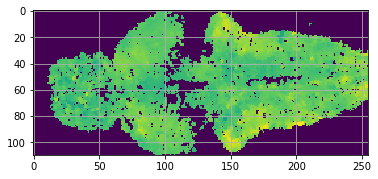

In [66]:
%matplotlib inline
plt.imshow(result_tr.mean((0,1))[20])
plt.grid('on')

In [46]:
result.shape

(1590, 35, 110, 255)

In [47]:
sample = result[:,20]

In [68]:
from scipy.signal import correlate

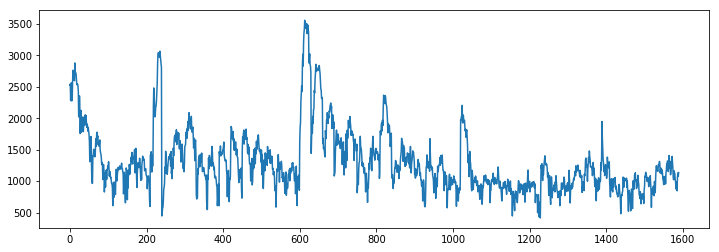

In [125]:
%matplotlib inline
roi_ts = sample[:,70:90,150:200].mean((1,2))
from scipy.stats import zscore
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(roi_ts)

In [89]:
corr = correlate(sample, roi_ts.reshape(-1,1,1))

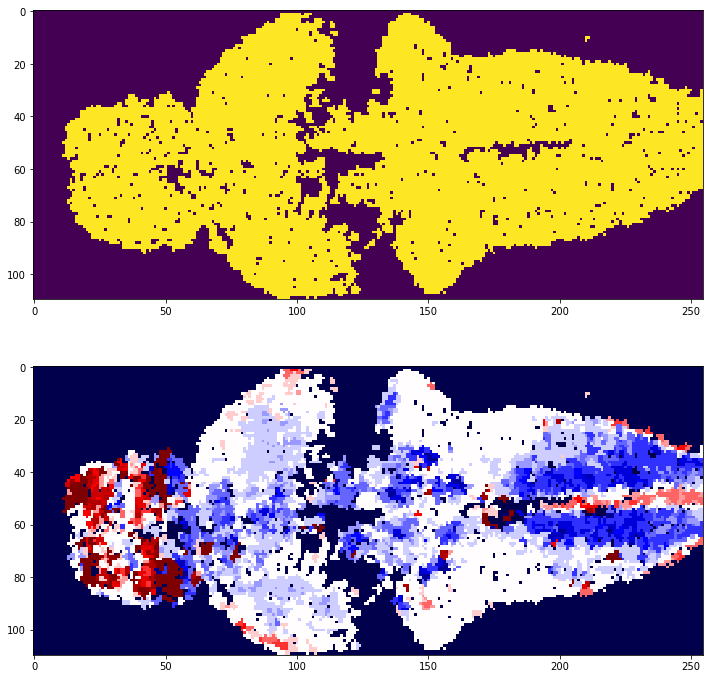

In [117]:
%matplotlib inline
fig, axs = plt.subplots(nrows=2, figsize=(12,12))
axs[0].imshow(corr.max(0) > 1)
axs[1].imshow(np.argmax(corr, axis=0) * (corr.max(0) > 1), clim=np.array([-10,10]) + corr.shape[0] // 2, cmap='seismic')

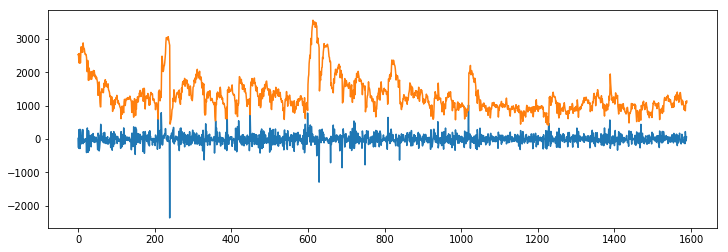

In [126]:
%matplotlib inline
roi_ts = sample[:,70:90,150:200].mean((1,2))
from scipy.stats import zscore
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(np.diff(roi_ts))
axs.plot(roi_ts)

In [177]:
%%time
# mika ignores first 130 frames
roi = (slice(140, -140), slice(None))
ts_full = get_mika_timeseries(base_dir + 'ana/Cells0_clust.mat', roi = roi)
coords,dims = get_mika_coords(base_dir + 'ana/Cells0_clean.mat')

CPU times: user 54.3 s, sys: 7.84 s, total: 1min 2s
Wall time: 1min 2s


In [310]:
cell_id = np.arange(ts_full.shape[1])
cell_id_vol = reconstruct_vol(cell_id, coords, dims).astype('int')

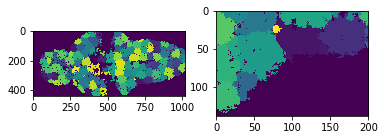

In [311]:
%matplotlib qt
z = 20
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(cell_id_vol[z])
roi_w = (slice(300, 450), slice(600, 800))
axs[1].imshow(cell_id_vol[z][roi_w])

In [180]:
coi = np.unique(cell_id_vol[z][roi_w])
coi = coi[coi > 0]

In [220]:
ts_raw = get_mika_timeseries(base_dir + '/ana/Cells0_clust.mat', key='Cell_timesers1').astype('float32')

In [642]:
%%time
from fish.image.vol import estimate_baseline
bl = estimate_baseline(ts_raw, window=100, percentile=10, downsample=4, axis=0).astype('float32')
bls = (ts_raw - bl).astype('float32')

CPU times: user 1min 46s, sys: 26.5 s, total: 2min 13s
Wall time: 2min 13s


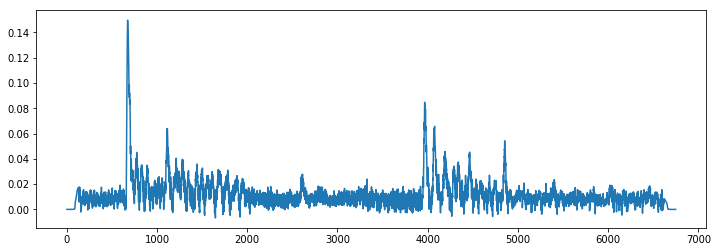

In [648]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(bls[:,coi].mean(1))

In [628]:
target = slice(None)

In [676]:
%%time
from scipy.stats import zscore
seed = bls[:,coi].mean(1)
from scipy.signal import correlate
corr = correlate(zscore(bls[:][:,target], axis=0), zscore(seed[:].reshape(-1,1), axis=0), mode='same')
corr_pk =np.argmax(corr, axis=0) - corr.shape[0] // 2

MemoryError: 

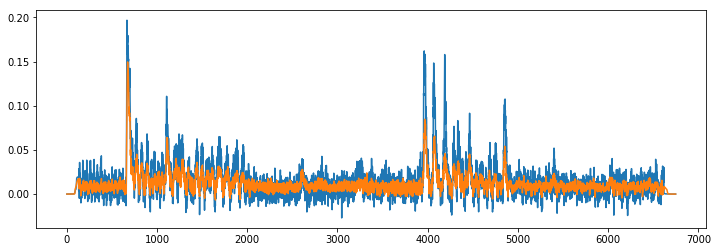

In [677]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(dff[:,np.argmax(corr.max(0))])
axs.plot(seed)

In [678]:
from matplotlib import cm
from skimage.exposure import rescale_intensity

v_mag = reconstruct_vol(rescale_intensity(corr.max(0), out_range=(0,1)), np.array(coords)[target], dims=dims, fill_value=0)
v_pk = reconstruct_vol(corr_pk, np.array(coords)[target], dims=dims, fill_value=0)
v_c = cm.seismic(rescale_intensity(v_pk.clip(-10,10), out_range=(0,1)))
v_c[:,:,:,:-1] *= v_mag.reshape(*v_mag.shape, 1)

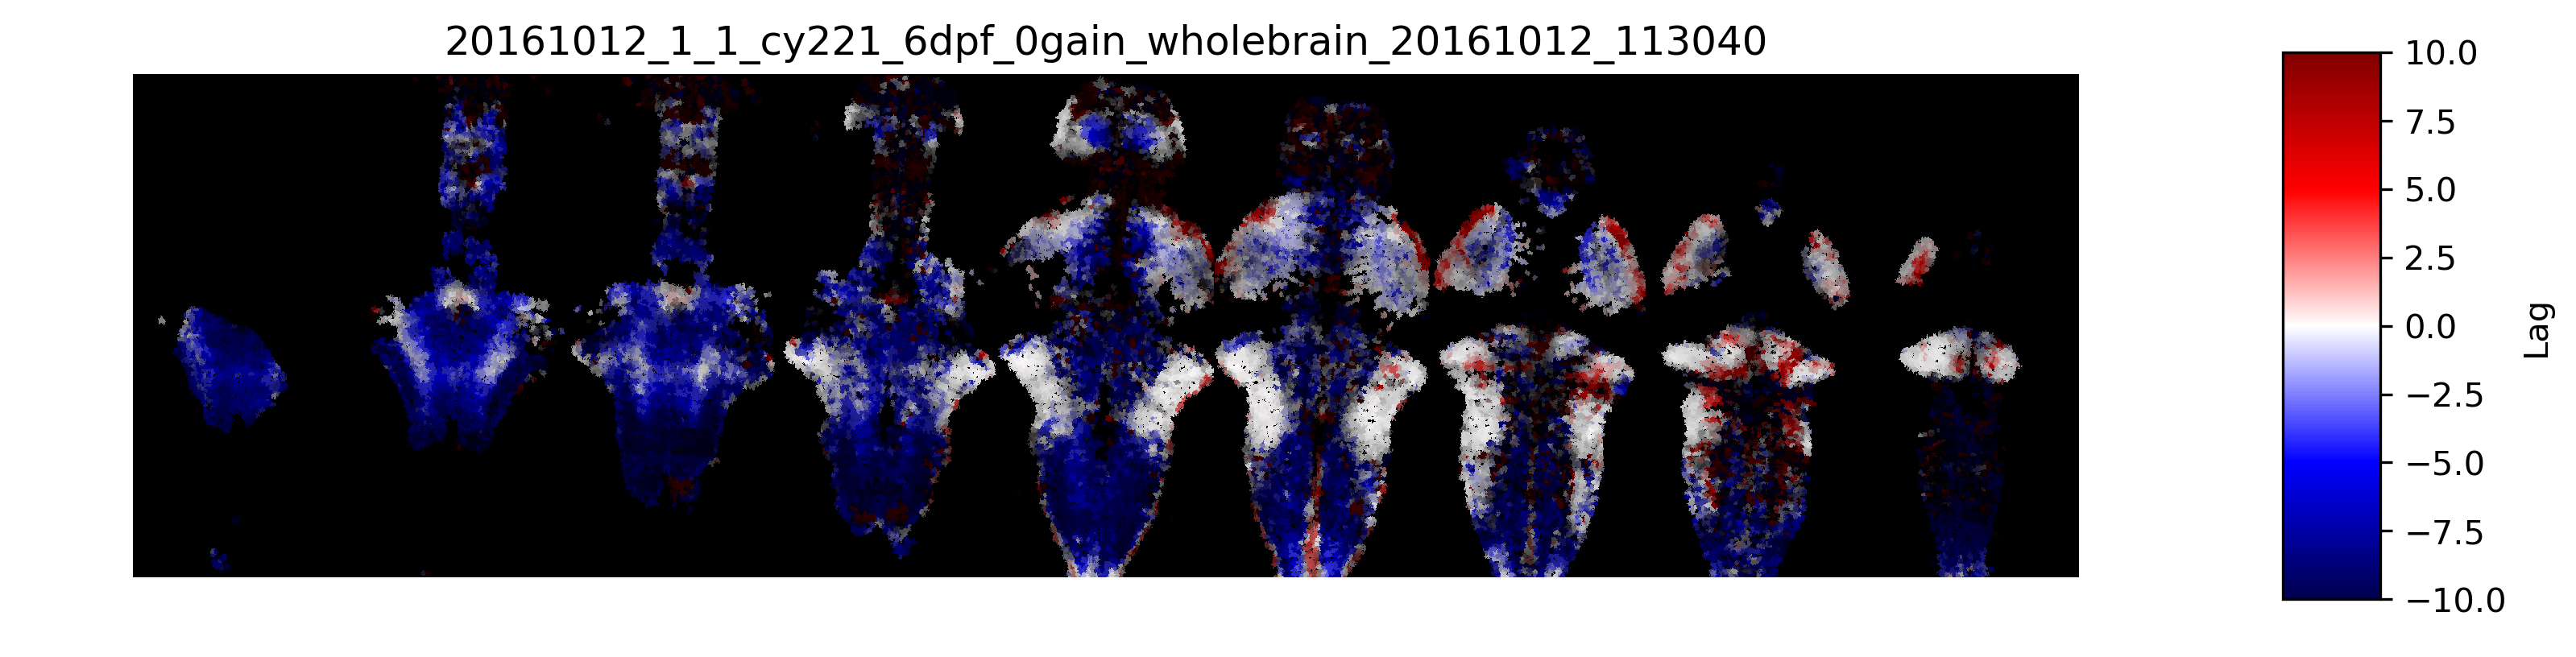

In [698]:
import matplotlib as mpl
fig, axs = plt.subplots(figsize=(12,3), dpi=300, ncols=2, gridspec_kw={'width_ratios' : (20,1)})
to_plot = v_c[::4]
axs[0].title.set_text(exp_name)
axs[0].imshow(to_plot.reshape(to_plot.shape[0] * to_plot.shape[1], *to_plot.shape[2:]).transpose(1,0,-1))
axs[0].axis('off')
cmap = cm.seismic
norm = mpl.colors.Normalize(vmin=-10, vmax=10)

cb1 = mpl.colorbar.ColorbarBase(axs[-1], cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Lag')


In [666]:
pq.image(v_c)

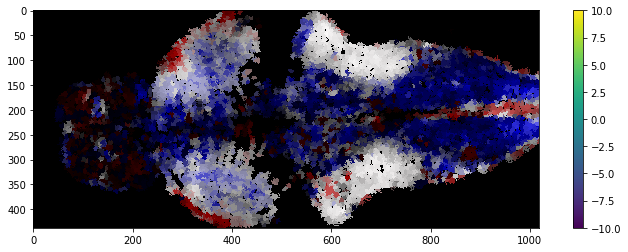

In [684]:
fig, axs = plt.subplots(figsize=(12,4))
axs.set_facecolor('k')
cax = axs.imshow(v_c[20], clim=np.array([-10,10]))
fig.colorbar(cax)